In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset
import numpy as np

In [2]:
X_train, y_train = next(iter(DataLoader(MNIST('./', train=True, download=True, transform=transforms.ToTensor()), batch_size=60000)))
X_test, y_test = next(iter(DataLoader(MNIST('./', train=False, download=True, transform=transforms.ToTensor()), batch_size=10000)))

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/home/david/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

In [4]:
train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True)

# Implem with pytorch first

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.softmax(x)
        return x

In [7]:
model = Net()

loss_function = nn.NLLLoss(reduction="none")
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
epochs = 5

losses, accuracies = [], []

for i in range(epochs):
    pbar = tqdm(train_dataloader)
    for batch in pbar:
        X, y = batch
        model.zero_grad()
        out = model.forward(X.view(-1, 784))
        yp = torch.argmax(out, dim=1)
        accuracy = (yp == y).float().mean()
        loss = loss_function(out, y)
        loss = loss.sum()
        loss.backward()
        optim.step()

        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
        pbar.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    y_test_preds = torch.argmax(model(X_test.view(-1, 784)), dim=1)
    val_acc = (y_test == y_test_preds).float().mean()
    print(f'val_acc: {val_acc}')

  0%|          | 0/469 [00:00<?, ?it/s]/home/david/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
loss 26.41 accuracy 0.92:   2%|▏         | 10/469 [00:00<00:04, 93.48it/s]

val_acc: 0.9150000214576721


loss 40.69 accuracy 0.91:   3%|▎         | 14/469 [00:00<00:03, 133.04it/s]

val_acc: 0.9298999905586243


loss 31.31 accuracy 0.91:   3%|▎         | 12/469 [00:00<00:03, 119.91it/s]

val_acc: 0.946399986743927


loss 14.28 accuracy 0.98:   3%|▎         | 12/469 [00:00<00:03, 119.73it/s]

val_acc: 0.9531999826431274


loss 14.56 accuracy 0.98: 100%|██████████| 469/469 [00:03<00:00, 121.24it/s]


val_acc: 0.9595000147819519


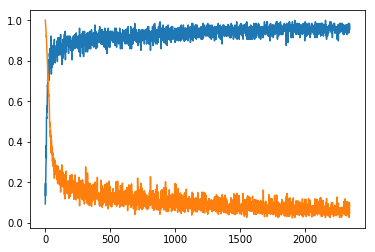

In [8]:
plt.plot(np.array(accuracies)/np.max(accuracies))
plt.plot(np.array(losses)/np.max(losses))

# With numpy

In [10]:
import numpy as np

def relu(x):
    return np.maximum(x, 0)

def softmax(x, dim=1):
    return np.exp(x) / np.sum(np.exp(x), dim).reshape(-1, 1)

def layer_init(in_features, out_features):
    return np.random.randn(in_features, out_features) * np.sqrt(2/out_features)

## Only one layer, no relu
Calculating derivative of cross entropy w.r.t to input of softmax (condensed way)  
https://peterroelants.github.io/posts/cross-entropy-softmax/

100%|██████████| 469/469 [00:03<00:00, 150.04it/s]


val acc 0.8982


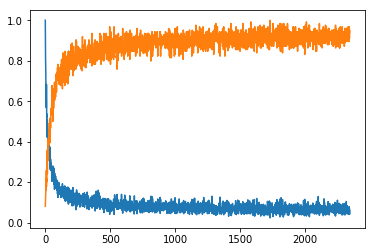

In [11]:
lr = 0.001
w1 = layer_init(784, 10)

losses, accuracies = [], []

for i in range(5):
    for X, y in tqdm(train_dataloader):

        X = X.view(-1, 784).numpy()
        y = y.numpy()
        y_one_hot = np.zeros((len(y), 10), np.float32)
        y_one_hot[range(y_one_hot.shape[0]), y] = 1

        # forward
        x_l1 = X.dot(w1)
        x_softmax = softmax(x_l1)
        x_log_softmax = np.log(x_softmax)
        loss = - y_one_hot * x_log_softmax
        loss = loss.sum()
        accuracy = (np.argmax(x_softmax, 1) == y).astype(np.float32).mean()

        # backward
        dloss_dl1 = x_softmax - y_one_hot
        dl1_dw1 = X.T

        dloss_dw1 = dl1_dw1.dot(dloss_dl1)

        # SGD
        w1 = w1 - lr * dloss_dw1

        losses.append(loss)
        accuracies.append(accuracy)

plt.plot(np.array(losses)/np.max(losses))
plt.plot(np.array(accuracies)/np.max(accuracies)) 

x_l1 = X_test.view(-1, 784).numpy().dot(w1)
x_softmax = softmax(x_l1)
print('val acc', (np.argmax(x_softmax, 1) == y_test.numpy()).astype(np.float32).mean())

## 2 layers and relu

100%|██████████| 469/469 [00:04<00:00, 115.57it/s]


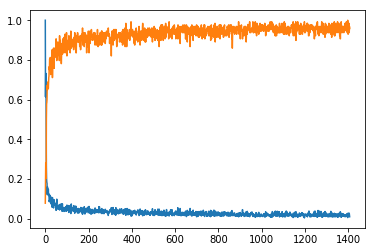

In [12]:
lr = 0.001
w1 = layer_init(784, 128)
w2 = layer_init(128, 10)

losses, accuracies = [], []

for i in range(3):
    for X, y in tqdm(train_dataloader):

        X = X.view(-1, 784).numpy()
        y = y.numpy()
        y_one_hot = np.zeros((len(y), 10), np.float32)
        y_one_hot[range(y_one_hot.shape[0]), y] = 1

        # forward
        x_l1 = X.dot(w1)
        x_relu = relu(x_l1)
        x_l2 = x_relu.dot(w2)
        x_softmax = softmax(x_l2)
        x_log_softmax = np.log(x_softmax)
        loss = - y_one_hot * x_log_softmax
        loss = loss.sum()
        accuracy = (np.argmax(x_softmax, 1) == y).astype(np.float32).mean()

        # backward
        dloss_dl2 = x_softmax - y_one_hot
        dl2_dw2 = x_relu.T
        dloss_dw2 = dl2_dw2.dot(dloss_dl2)
        
        dl2_drelu = w2.T
        drelu_dl1 = (x_l1 > 0).astype(np.float32)
        dl1_dw1 = X.T
                
        dloss_dw1 = dl1_dw1.dot(dloss_dl2.dot(dl2_drelu) * drelu_dl1)

        # SGD
        w1 = w1 - lr * dloss_dw1
        w2 = w2 - lr * dloss_dw2

        losses.append(loss)
        accuracies.append(accuracy)
        
plt.plot(np.array(losses)/np.max(losses))
plt.plot(np.array(accuracies)/np.max(accuracies)) 


In [14]:
x_l1 = X_test.view(-1, 784).numpy().dot(w1)
x_relu = relu(x_l1)
x_l2 = x_relu.dot(w2)
x_softmax = softmax(x_l2)
print('val acc', (np.argmax(x_softmax, 1) == y_test.numpy()).astype(np.float32).mean())

val acc 0.9558


pred 3


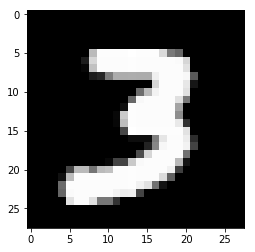

In [13]:
random_idx = np.random.choice(len(X_test))
x_sample = X_test[random_idx]
x_l1 = x_sample.view(1, 784).numpy().dot(w1)
x_relu = relu(x_l1)
x_l2 = x_relu.dot(w2)
x_softmax = softmax(x_l2)
pred = np.argmax(x_softmax)

print('pred', pred)
plt.imshow(x_sample.numpy()[0], cmap='gray')

# Using complete chain rule 
Calculating derivative of cross entropy w.r.t softmax
and then derivative of softmax w.r.t input

## gradient of softmax

In [14]:
x = np.array([[1., 2., 3.], [1., 2., 3.], [1., 2., 3.]]).astype(np.float32)
x_softmax = softmax(x, 1)

diag_softmax = np.concatenate([np.expand_dims(np.diag(vec), 0) for vec in x_softmax])
softmax_matrix = np.tile(np.expand_dims(x_softmax, 2), x_softmax.shape[1])
dsoftmax_dx = diag_softmax - softmax_matrix * np.transpose(softmax_matrix, (0, 2, 1))

In [15]:
(np.expand_dims(x, 1) @ (dsoftmax_dx)).reshape(-1, 3)

array([[-0.1418171 , -0.14077032,  0.28258747],
       [-0.1418171 , -0.14077032,  0.28258747],
       [-0.1418171 , -0.14077032,  0.28258747]], dtype=float32)

In [16]:
torch_x = torch.tensor(x, requires_grad=True, dtype=torch.float32)
torch_x.retain_grad()
torch_sm = torch.softmax(torch_x, 1)
torch_sm.retain_grad()
torch_sm.backward(torch_x)

In [17]:
# pytorch actually computes X.dot(Jacobian)
torch_x.grad

tensor([[-0.1418, -0.1408,  0.2826],
        [-0.1418, -0.1408,  0.2826],
        [-0.1418, -0.1408,  0.2826]])

## One layer no relu (but full chain rule)

In [18]:
lr = 0.001
w1 = layer_init(784, 10)

losses, accuracies = [], []

for i in range(5):
    for X, y in tqdm(train_dataloader):

        X = X.view(-1, 784).numpy()
        y = y.numpy()
        y_one_hot = np.zeros((len(y), 10), np.float32)
        y_one_hot[range(y_one_hot.shape[0]), y] = 1

        # forward
        x_l1 = X.dot(w1)
        x_softmax = softmax(x_l1)
        x_log_softmax = np.log(x_softmax)
        loss = - y_one_hot * x_log_softmax
        loss = loss.sum()
        accuracy = (np.argmax(x_softmax, 1) == y).astype(np.float32).mean()

        # backward
        dlog_dsoftmax = - y_one_hot / x_softmax
        
        diag_softmax = np.concatenate([np.expand_dims(np.diag(vec), 0) for vec in x_softmax])
        softmax_matrix = np.tile(np.expand_dims(x_softmax, 2), x_softmax.shape[1])
        dsoftmax_dl1 = diag_softmax - softmax_matrix * np.transpose(softmax_matrix, (0, 2, 1))
                
        dloss_dl1 = (np.expand_dims(dlog_dsoftmax, 1) @ (dsoftmax_dl1)).reshape(-1, 10)


        dl1_dw1 = X.T
        
        dloss_dw1 = dl1_dw1.dot(dloss_dl1)

        # SGD
        w1 = w1 - lr * dloss_dw1

        losses.append(loss)
        accuracies.append(accuracy)

100%|██████████| 469/469 [00:03<00:00, 129.19it/s]


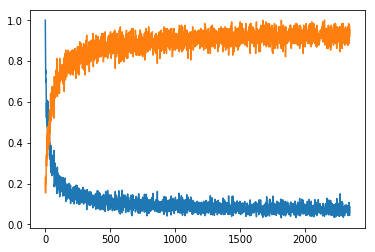

In [19]:
plt.plot(np.array(losses)/np.max(losses))
plt.plot(np.array(accuracies)/np.max(accuracies)) 